In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
# Inputs
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import Imputer

# Data viz
from mlens.visualization import corr_X_y, corrmat

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator

# Ensemble
from mlens.ensemble import SuperLearner

from scipy.stats import uniform, randint
from matplotlib.pyplot import show


%matplotlib inline

[MLENS] backend: threading


In [2]:
pd.set_option('display.max_columns', 100)

mpl.rc(group='figure', figsize=(10,8))
plt.style.use('seaborn')

In [3]:
X_train = pd.read_csv('dataset/dengue_features_train.csv')
X_train.week_start_date = pd.to_datetime(X_train.week_start_date)
print(f'X_train: {X_train.shape}')

y_train = pd.read_csv('dataset/dengue_labels_train.csv', 
                      usecols=['total_cases'])
print(f'y_train: {y_train.shape}')

X_test = pd.read_csv('dataset/dengue_features_test.csv')
X_test.week_start_date = pd.to_datetime(X_test.week_start_date)
print(f'X_test: {X_test.shape}')

X_train: (1456, 24)
y_train: (1456, 1)
X_test: (416, 24)


Combine train and test dataset

In [4]:
Xy_train = pd.concat([y_train, X_train], axis=1) 
print(f'Xy_train: {Xy_train.shape}')
Xy_train.head()

Xy_train: (1456, 25)


,total_cases,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,4,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,5,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,4,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,6,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Split sj and iq

In [5]:
Xy_sj = Xy_train.loc[Xy_train.city == 'sj', :]
Xy_iq = Xy_train.loc[Xy_train.city == 'iq', :]
print(f'Xy_sj: {Xy_sj.shape}')
print(f'Xy_iq: {Xy_iq.shape}')

Xy_sj: (936, 25)
Xy_iq: (520, 25)


In [6]:
Xy_sj.corr().total_cases.sort_values(ascending=False)


total_cases                              1.000000
weekofyear                               0.287134
reanalysis_specific_humidity_g_per_kg    0.207947
reanalysis_dew_point_temp_k              0.203774
station_avg_temp_c                       0.196617
reanalysis_max_air_temp_k                0.194532
station_max_temp_c                       0.189901
reanalysis_min_air_temp_k                0.187943
reanalysis_air_temp_k                    0.181917
station_min_temp_c                       0.177012
reanalysis_avg_temp_k                    0.175267
reanalysis_relative_humidity_percent     0.144045
reanalysis_precip_amt_kg_per_m2          0.107457
ndvi_nw                                  0.075307
reanalysis_sat_precip_amt_mm             0.060211
precipitation_amt_mm                     0.060211
station_precip_mm                        0.051759
ndvi_ne                                  0.037639
station_diur_temp_rng_c                  0.034630
ndvi_se                                  0.001113


In [7]:
Xy_iq.corr().total_cases.sort_values(ascending=False)


total_cases                              1.000000
reanalysis_specific_humidity_g_per_kg    0.236476
reanalysis_dew_point_temp_k              0.230401
reanalysis_min_air_temp_k                0.214514
station_min_temp_c                       0.211702
year                                     0.179451
reanalysis_relative_humidity_percent     0.130083
station_avg_temp_c                       0.113070
reanalysis_precip_amt_kg_per_m2          0.101171
reanalysis_air_temp_k                    0.097098
precipitation_amt_mm                     0.090171
reanalysis_sat_precip_amt_mm             0.090171
reanalysis_avg_temp_k                    0.079872
station_max_temp_c                       0.075279
station_precip_mm                        0.042976
ndvi_sw                                  0.032999
ndvi_ne                                  0.020215
ndvi_nw                                 -0.009586
weekofyear                              -0.011850
ndvi_se                                 -0.041067


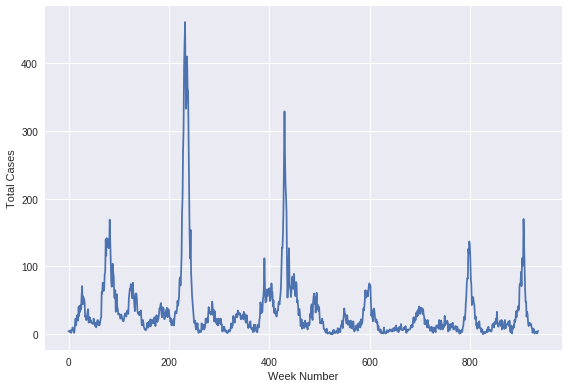

In [8]:
Xy_sj.total_cases.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Total Cases')
plt.tight_layout()

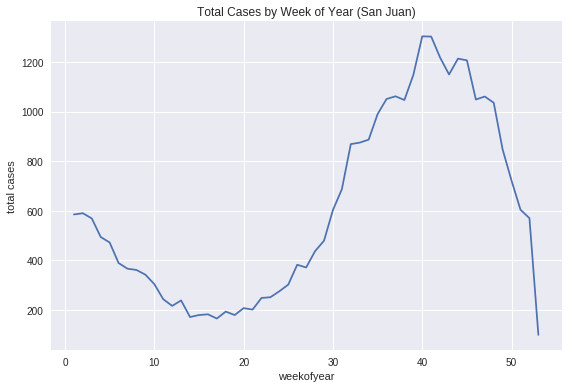

In [9]:
Xy_sj.groupby(['weekofyear']).total_cases.sum().plot(kind='line')
plt.ylabel('total cases')
plt.title('Total Cases by Week of Year (San Juan)')
plt.tight_layout()

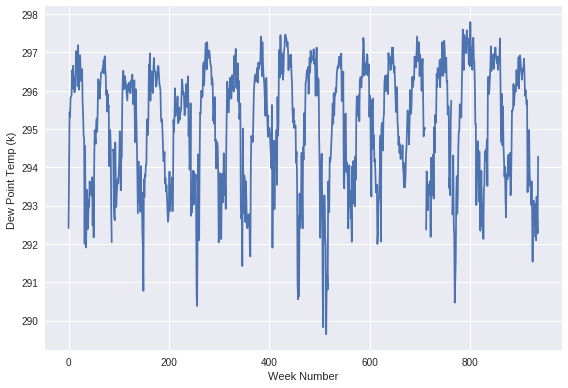

In [10]:
Xy_sj.reanalysis_dew_point_temp_k.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Dew Point Temp (k) ')
plt.tight_layout()

In [11]:
# to restore data into orginal order
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [12]:
X_train_sj = X_train.loc[X_train.city == 'sj', :].copy()
X_train_iq = X_train.loc[X_train.city == 'iq', :].copy()

y_train_sj = y_train.loc[X_train.city == 'sj', :].copy()
y_train_iq = y_train.loc[X_train.city == 'iq', :].copy()

print(f'X_train_sj: {X_train_sj.shape}')
print(f'X_train_iq: {X_train_iq.shape}')
print(f'y_train_sj: {y_train_sj.shape}')
print(f'y_train_iq: {y_train_iq.shape}')

X_train_sj: (936, 25)
X_train_iq: (520, 25)
y_train_sj: (936, 1)
y_train_iq: (520, 1)


In [13]:
# split test data
X_test_sj = X_test.loc[X_test.city == 'sj', :].copy()
X_test_iq = X_test.loc[X_test.city == 'iq', :].copy()
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_test_sj: (260, 25)
X_test_iq: (156, 25)


In [14]:
keys = ['city', 'year', 'weekofyear']

all_features = ['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

sj_features = ['reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 
            'station_avg_temp_c',  'station_max_temp_c', 'station_min_temp_c']
iq_features = ['reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg', 
            'station_avg_temp_c', 'station_min_temp_c']
features = ['reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 
            'station_avg_temp_c',  'station_max_temp_c', 'station_min_temp_c']

new_features = ['recent_mean_dew_point', 'recent_mean_spec_humid', 'recent_sum_precip']

time_series_features = ['week_start_date']

drop_features = list(set(all_features) - set(features) - set(keys) - set(time_series_features))

drop_sj_features = list(set(all_features) - set(sj_features) - set(keys) - set(time_series_features))

drop_iq_features = list(set(all_features) - set(iq_features) - set(keys) - set(time_series_features))

print('drop_features:\n', sorted(drop_features))

drop_features:
 ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_precip_mm']


In [15]:
# impute missing values and redundant columns
impute_columns = ['reanalysis_avg_temp_c', 'reanalysis_max_air_temp_c', 
                  'reanalysis_min_air_temp_c']

def impute_redundant_features(df):
    # Convert temperature from kelvin to celcius so we can attempt to correct 
    # for the difference between the two redundant temperature features 
    # (i.e. reanalysis and station).
    df['reanalysis_avg_temp_c'] = df.reanalysis_avg_temp_k - 273.15
    df.reanalysis_avg_temp_c -= (df.reanalysis_avg_temp_c - df.station_avg_temp_c).mean()
    df.loc[df.station_avg_temp_c.isnull(), 'station_avg_temp_c'] = df.reanalysis_avg_temp_c

    df['reanalysis_max_air_temp_c'] = df.reanalysis_max_air_temp_k - 273.15
    df.reanalysis_max_air_temp_c -= (df.reanalysis_max_air_temp_c - df.station_max_temp_c).mean()
    df.loc[df.station_max_temp_c.isnull(), 'station_max_temp_c'] = df.reanalysis_max_air_temp_c

    df['reanalysis_min_air_temp_c'] = df.reanalysis_min_air_temp_k - 273.15
    df.reanalysis_min_air_temp_c -= (df.reanalysis_min_air_temp_c - df.station_min_temp_c).mean()
    df.loc[df.station_min_temp_c.isnull(), 'station_min_temp_c'] = df.reanalysis_min_air_temp_c
    
    # Drop the temporary columns that we just added
    df.drop(impute_columns, axis=1, inplace=True)
    
    return df

In [16]:
X_train_sj = impute_redundant_features(X_train_sj)
X_train_iq = impute_redundant_features(X_train_iq)

X_test_sj = impute_redundant_features(X_test_sj)
X_test_iq = impute_redundant_features(X_test_iq)

In [17]:
def impute_missing_values(df, imputer):
    imputer.fit(df[features])
    df[features] = imputer.transform(df[features])
    return df

In [18]:
imputer_sj = Imputer(strategy='mean')
X_train_sj = impute_missing_values(X_train_sj, imputer_sj)
X_test_sj = impute_missing_values(X_test_sj, imputer_sj)

imputer_iq = Imputer(strategy='mean')
X_train_iq = impute_missing_values(X_train_iq, imputer_iq)
X_test_iq = impute_missing_values(X_test_iq, imputer_iq)

Feature extraction

In [19]:
def add_time_series_features(df, window):
    df.set_index('week_start_date', inplace=True)

    roll_df = df.rolling(window=window, min_periods=1)
    df['recent_mean_dew_point'] = roll_df.reanalysis_dew_point_temp_k.mean()
    df['recent_mean_spec_humid'] = roll_df.reanalysis_specific_humidity_g_per_kg.mean()
    df['recent_sum_precip'] = roll_df.reanalysis_precip_amt_kg_per_m2.sum()
    
    df.reset_index(inplace=True)    
    return df

In [20]:
X_train_sj = add_time_series_features(X_train_sj, window=100)
X_train_iq = add_time_series_features(X_train_iq, window=30)
X_test_sj = add_time_series_features(X_test_sj, window=100)
X_test_iq = add_time_series_features(X_test_iq, window=30)

print(f'X_train_sj: {X_train_sj.shape}')
print(f'X_train_iq: {X_train_iq.shape}')
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_train_sj: (936, 28)
X_train_iq: (520, 28)
X_test_sj: (260, 28)
X_test_iq: (156, 28)


In [21]:
def drop_unnecessary_features(df):
    df.drop(drop_features, axis=1, inplace=True)
    df.drop(time_series_features, axis=1, inplace=True)
    return df

In [22]:
def drop_sj_unnecessary_features(df):
    df.drop(drop_sj_features, axis=1, inplace=True)
    df.drop(time_series_features, axis=1, inplace=True)
    return df

In [23]:
def drop_iq_unnecessary_features(df):
    df.drop(drop_iq_features, axis=1, inplace=True)
    df.drop(time_series_features, axis=1, inplace=True)
    return df

In [24]:
X_train_sj = drop_unnecessary_features(X_train_sj)
X_train_iq = drop_unnecessary_features(X_train_iq)
X_test_sj = drop_unnecessary_features(X_test_sj)
X_test_iq = drop_unnecessary_features(X_test_iq)

print(f'X_train_sj: {X_train_sj.shape}')
print(f'X_train_iq: {X_train_iq.shape}')
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_train_sj: (936, 13)
X_train_iq: (520, 13)
X_test_sj: (260, 13)
X_test_iq: (156, 13)


In [25]:
# normalize data
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

In [26]:
features_to_normalize = features + new_features

X_train_sj[features_to_normalize] = X_train_sj[features_to_normalize].apply(normalize, axis=0)
X_train_iq[features_to_normalize] = X_train_iq[features_to_normalize].apply(normalize, axis=0)
X_test_sj[features_to_normalize] = X_test_sj[features_to_normalize].apply(normalize, axis=0)
X_test_iq[features_to_normalize] = X_test_iq[features_to_normalize].apply(normalize, axis=0)

In [27]:
# restore dataset to original index
X_train = pd.concat([X_train_sj, X_train_iq], axis=0)
X_train.set_index('index', inplace=True)
X_train.head()

,city,year,weekofyear,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_max_temp_c,station_min_temp_c,recent_mean_dew_point,recent_mean_spec_humid,recent_sum_precip
index,,,,,,,,,,,,
0,sj,1990,18,-1.722306,0.043211,-1.632200,-1.108260,-1.289862,-1.732105,-9.463572,-8.929043,-3.733679
1,sj,1990,19,-0.740042,-0.352694,-0.758112,-0.207129,0.053770,-0.266841,-6.794441,-6.566003,-3.710537
2,sj,1990,20,0.207532,-0.122923,0.190347,-0.207129,0.345864,0.132776,-4.188151,-4.068925,-3.676869
3,sj,1990,21,0.128111,-0.466453,0.077414,0.329500,0.988471,0.465791,-2.992913,-2.973040,-3.658939
4,sj,1990,22,0.454924,-0.514322,0.422642,1.372383,1.981591,0.865408,-1.920547,-1.942189,-3.643202


In [28]:
X_sj, y_sj = X_train.loc[X_train.city == 'sj', :], y_train.loc[X_train.city == 'sj', :]
X_iq, y_iq = X_train.loc[X_train.city == 'iq', :], y_train.loc[X_train.city == 'iq', :]
print(f'X_sj: {X_sj.shape}')
print(f'y_sj: {y_sj.shape}')
print(f'X_iq: {X_iq.shape}')
print(f'y_iq: {y_iq.shape}')

X_sj: (936, 12)
y_sj: (936, 1)
X_iq: (520, 12)
y_iq: (520, 1)


In [29]:
X_train_sj, X_cross_sj, y_train_sj, y_cross_sj = train_test_split(X_sj, 
                                                                  y_sj,
                                                                  test_size=0.2,
                                                                  stratify=X_sj.weekofyear)

print(f'X_train_sj: {X_train_sj.shape}')
print(f'y_train_sj: {y_train_sj.shape}')
print(f'X_cross_sj: {X_cross_sj.shape}')
print(f'y_cross_sj: {y_cross_sj.shape}')

X_train_sj: (748, 12)
y_train_sj: (748, 1)
X_cross_sj: (188, 12)
y_cross_sj: (188, 1)


In [30]:
X_train_iq, X_cross_iq, y_train_iq, y_cross_iq = train_test_split(X_iq, 
                                                                  y_iq, 
                                                                  test_size=0.2,
                                                                  stratify=X_iq.weekofyear)

print(f'X_train_iq: {X_train_iq.shape}')
print(f'y_train_iq: {y_train_iq.shape}')
print(f'X_cross_iq: {X_cross_iq.shape}')
print(f'y_cross_iq: {y_cross_iq.shape}')

X_train_iq: (416, 12)
y_train_iq: (416, 1)
X_cross_iq: (104, 12)
y_cross_iq: (104, 1)


In [31]:
def drop_unnecessary_columns(df):
    return df[features + new_features + ['weekofyear']]

In [32]:
def drop_sj_unnecessary_columns(df):
    return df[sj_features + new_features + ['weekofyear']]

In [33]:
def drop_iq_unnecessary_columns(df):
    return df[iq_features + new_features + ['weekofyear']]

In [34]:
X_train_sj = drop_unnecessary_columns(X_train_sj)
X_train_iq = drop_unnecessary_columns(X_train_iq)
X_cross_sj = drop_unnecessary_columns(X_cross_sj)
X_cross_iq = drop_unnecessary_columns(X_cross_iq)

X_train_sj.drop(['station_min_temp_c'], axis=1, inplace=True)
X_train_iq.drop(['station_min_temp_c'], axis=1, inplace=True)
X_cross_sj.drop(['station_min_temp_c'], axis=1, inplace=True)
X_cross_iq.drop(['station_min_temp_c'], axis=1, inplace=True)
# X_train_sj = drop_sj_unnecessary_columns(X_train_sj)
# X_train_iq = drop_iq_unnecessary_columns(X_train_iq)
# X_cross_sj = drop_sj_unnecessary_columns(X_cross_sj)
# X_cross_iq = drop_iq_unnecessary_columns(X_cross_iq)

print(f'X_train_iq: {X_train_iq.shape}')
print(f'y_train_iq: {y_train_iq.shape}')
print(f'X_cross_iq: {X_cross_iq.shape}')
print(f'y_cross_iq: {y_cross_iq.shape}')

X_train_iq: (416, 9)
y_train_iq: (416, 1)
X_cross_iq: (104, 9)
y_cross_iq: (104, 1)


In [35]:
def train_predict_score(reg, X, y):
    reg.fit(X, y)
    y_pred = reg.predict(X)
    return mean_absolute_error(y_true=y, y_pred=y_pred)

In [36]:
reg = DummyRegressor(strategy='mean')
print('San Juan: ', round(train_predict_score(reg, X_train_sj, y_train_sj), 4))
print('Iquitos: ', round(train_predict_score(reg, X_train_iq, y_train_iq), 4))

San Juan:  28.2088
Iquitos:  6.7938


In [37]:
def train_cross_val_score(reg, X, y, scoring='neg_mean_absolute_error'):
    reg.fit(X, y)
    scores = np.abs(cross_val_score(reg, X, y, scoring=scoring))
    print("Scores: {}".format(scores))
    print("Avg Score: {}".format(scores.mean()))

Liner Regression

In [38]:
# reg = LinearRegression(n_jobs=-1)
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq)

KNN

In [39]:
# reg = KNeighborsRegressor(n_jobs=-1)
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq)

SVM

In [40]:
# reg = SVR(kernel='linear')
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

In [41]:
# reg = SVR(kernel='rbf')
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

Gradient boosting

In [42]:
# reg = GradientBoostingRegressor(criterion='mae', random_state=67)
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

MLP

In [43]:
# reg = MLPRegressor(max_iter=3000, random_state=67)
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

Random Forest

In [44]:
# reg = RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=67)
# print('San Juan:')
# train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
# print('\nIquitos:')
# train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

In [45]:
def grid_search_cross_val(reg, X, y, param_grid, scoring='neg_mean_absolute_error'):
    grid = GridSearchCV(reg, param_grid=param_grid, scoring=scoring)
    grid.fit(X, y)
    print("Best score: {}".format(np.abs(grid.best_score_)))
    print("Best params: {}".format(grid.best_params_))

Gradiaent boosting and RF with grid search

In [46]:
# %%time
# reg = GradientBoostingRegressor(random_state=67)

# param_grid = [
#     {'learning_rate': [0.1, 0.3, 1.0, 3.0], 'n_estimators': [10, 30, 100, 300, 500], 
#      'max_depth': [3, 5, 7, 9]}
# ]

# grid_search_cross_val(reg, X_train_sj, y_train_sj.total_cases, param_grid)
# grid_search_cross_val(reg, X_train_iq, y_train_iq.total_cases, param_grid)

In [47]:
# %%time
# reg = RandomForestRegressor(random_state=67)

# param_grid = [
#     {
#       'n_estimators': [10, 30, 100, 300, 500], 
#       'max_depth': [3, 5, 7, None]
#     } 
# ]

# grid_search_cross_val(reg, X_train_sj, y_train_sj.total_cases, param_grid)
# grid_search_cross_val(reg, X_train_iq, y_train_iq.total_cases, param_grid)

Cross validation from outside data

In [48]:
def cross_validate_out_of_sample(reg, X_train, y_train, X_cross, y_cross):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_cross)
    return mean_absolute_error(y_true=y_cross, y_pred=y_pred)

In [49]:
# GB sj
reg_sj = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_sj, X_train_sj, y_train_sj.total_cases, X_cross_sj, y_cross_sj.total_cases)


17.4995708181034

In [50]:
# GB iq
reg_iq = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_iq, X_train_iq, y_train_iq.total_cases, X_cross_iq, y_cross_iq.total_cases)

5.480372889777614

In [105]:
# RF sj
reg_sj = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_sj, X_train_sj, y_train_sj.total_cases, X_cross_sj, y_cross_sj.total_cases)



21.2842220615166

In [52]:
# # RF iq
reg_iq = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_iq, X_train_iq, y_train_iq.total_cases, X_cross_iq, y_cross_iq.total_cases)

5.4544180859845675

Make submission file

In [53]:
predict_sj = X_test_sj[keys].copy()
predict_iq = X_test_iq[keys].copy()

In [54]:
X_sj = drop_unnecessary_columns(X_sj)
X_iq = drop_unnecessary_columns(X_iq)
X_test_sj = drop_unnecessary_columns(X_test_sj)
X_test_iq = drop_unnecessary_columns(X_test_iq)


print(f'X_sj: {X_sj.shape}')
print(f'X_iq: {X_iq.shape}')
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_sj: (936, 10)
X_iq: (520, 10)
X_test_sj: (260, 10)
X_test_iq: (156, 10)


In [55]:
# Train models with full dataset
reg_sj = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, random_state=67)
reg_sj.fit(X_sj, y_sj.total_cases)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=67,
             subsample=1.0, verbose=0, warm_start=False)

Text(0,0.5,'Cases')

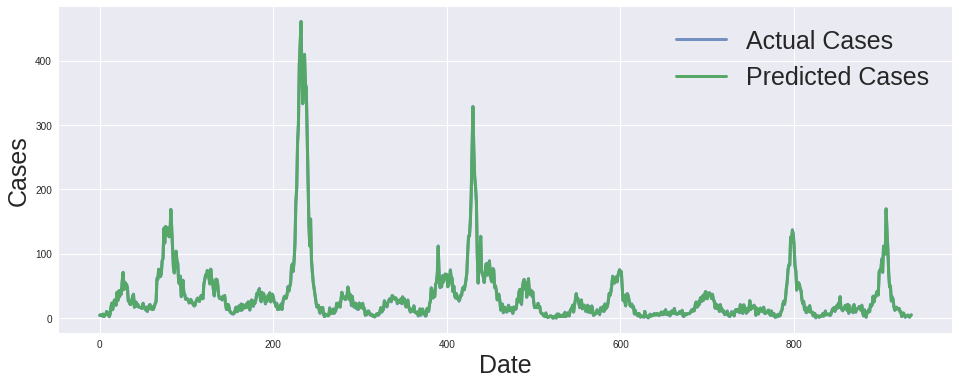

In [56]:
predsj = reg_sj.predict(X_sj)
pred_cases = pd.Series(predsj)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(y_sj.index, y_sj.total_cases, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(pred_cases.index, pred_cases, label = 'Predicted Cases', linewidth = 3)
# print (mean_absolute_error(pred_cases[:520], cases_iq))

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

In [57]:
reg_iq = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, random_state=67)
reg_iq.fit(X_iq, y_iq.total_cases)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=67,
             subsample=1.0, verbose=0, warm_start=False)

In [58]:
# reg_sj = RandomForestRegressor(max_depth=None, n_estimators=500, random_state=67)
# reg_sj.fit(X_sj, y_sj.total_cases)

In [59]:
# reg_iq = RandomForestRegressor(max_depth=None, n_estimators=500, random_state=67)
# reg_iq.fit(X_iq, y_iq.total_cases)

Create ensemble model

In [60]:
SEED = 148
np.random.seed(SEED)

In [61]:
# # We consider the following models (or base learners)
# gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, random_state=67)
# ls = Lasso(alpha=1e-6, normalize=True)
# el = ElasticNet(alpha=1e-6, normalize=True)
# rf = RandomForestRegressor(random_state=SEED)
# lr = LinearRegression()

# base_learners = [
#     ('ls', ls), ('el', el), ('rf', rf), ('gb', gb), ('lr', lr)
# ]

In [62]:
# P = np.zeros((X_cross_sj.shape[0], len(base_learners)))
# P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

# for est_name, est in base_learners:
#     est.fit(X_train_sj, y_train_sj.total_cases)
#     p = est.predict(X_cross_sj)
#     P.loc[:, est_name] = p
#     print("%3s : %.4f" % (est_name, mean_absolute_error(y_cross_sj.total_cases, p)))

In [63]:
# reg_iq = RandomForestRegressor(max_depth=None, n_estimators=500, random_state=67)
# reg_iq.fit(X_iq, y_iq.total_cases)

In [64]:
y_sj_pred = reg_sj.predict(X_test_sj)
predict_sj['total_cases'] = y_sj_pred.round().astype(int)
predict_sj.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,7
2,sj,2008,20,7
3,sj,2008,21,7
4,sj,2008,22,7


In [65]:
y_iq_pred = reg_iq.predict(X_test_iq)
predict_iq['total_cases'] = y_iq_pred.round().astype(int)
predict_iq.head()

,city,year,weekofyear,total_cases
0,iq,2010,26,0
1,iq,2010,27,2
2,iq,2010,28,9
3,iq,2010,29,-2
4,iq,2010,30,0


In [66]:
predict_df = pd.concat([predict_sj, predict_iq], axis=0)
predict_df[predict_df.total_cases < 0]


,city,year,weekofyear,total_cases
47,sj,2009,13,-2
3,iq,2010,29,-2


In [67]:
predict_df.loc[predict_df.total_cases < 0, 'total_cases'] = 0


In [68]:
submission_filename = 'submissions/rolling_window_RF_18:23.csv'
predict_df.to_csv(submission_filename, index=False)

In [69]:
df1 = pd.read_csv('dataset/submission_format.csv', 
                  usecols=[0, 1, 2], header=0, names=['format_city', 'format_year', 'format_weekofyear'])

df2 = pd.read_csv(submission_filename, 
                  usecols=[0, 1, 2], header=0, names=['submit_city', 'submit_year', 'submit_weekofyear'])

df = pd.merge(df1, df2, how='left', 
              left_on=['format_city', 'format_year', 'format_weekofyear'], 
              right_on=['submit_city', 'submit_year', 'submit_weekofyear'])

df[(df['format_city'] != df['submit_city']) | 
   (df['format_year'] != df['submit_year']) | 
   (df['format_weekofyear'] != df['submit_weekofyear'])]

,format_city,format_year,format_weekofyear,submit_city,submit_year,submit_weekofyear


In [77]:
# ensemble Rooling windows and residual predictions
residual_data = pd.read_csv('submissions/residual_prediction_weather2_RF.csv')
rolling_data = pd.read_csv('submissions/rolling_window_RF_18:23.csv')

residuals = pd.read_csv('submissions/residual_prediction_weather2_RF.csv')['total_cases']
rolling_window = pd.read_csv('submissions/rolling_window_RF_18:23.csv')['total_cases']
# random_forest = pd.read_csv('submissions/rolling_window_RF_18:23.csv')['total_cases'



# print(mean_prediction)

# submission_format = pd.read_csv('./dataset/submission_format.csv')

# submission_format['total_cases'] = mean_prediction
weighted_predictions = []
for x in range (2, 4):
    mean_prediction = (residuals*(1/x) + rolling_window*(1-(1/x)))
    weighted_predictions.append(mean_prediction)
#     mean_prediction = list(map(int, mean_prediction))
#     print(x, mean_prediction)
#     break
mean_prediction = [sum(y) for y in zip(*weighted_predictions)]
mean_prediction = [k / 2 for k in mean_prediction]
# mean_prediction = (residuals + rolling_window + random_forest)/3
# print(mean_prediction)

submission_format = pd.read_csv('./dataset/submission_format.csv')
submission_format['total_cases'] = mean_prediction
submission_format['total_cases']= submission_format['total_cases'].apply(lambda x: int(x))
# print(submission_format['total_cases'])
# submission_format['total_cases'] = mean_prediction
# Save to CSV, use current date
submission_format.to_csv('./submissions/ensemble_rf_gb_13-51.csv', index=False)

In [103]:
# ensemble Rooling windows and residual predictions
residual_data = pd.read_csv('submissions/residual_prediction_weather2_RF.csv')
rolling_data = pd.read_csv('submissions/rolling_window_RF_18:23.csv')

sj_res = residual_data.loc[residual_data.city == 'sj', :]
sj_roll = rolling_data.loc[rolling_data.city == 'sj', :]
sj_res_cases = sj_res['total_cases']
sj_roll_cases = sj_roll['total_cases']


iq_res = residual_data.loc[residual_data.city == 'iq', :]
iq_roll = rolling_data.loc[rolling_data.city == 'iq', :]
iq_res_cases = iq_res['total_cases']
iq_roll_cases = iq_roll['total_cases']


weighted_predictions = []
for x in range (3, 4):
    mean_sj_prediction = (sj_res_cases*(1/x) + sj_roll_cases*(1-(1/x)))
    weighted_predictions.append(mean_sj_prediction)
#     mean_prediction = list(map(int, mean_prediction))
#     print(x, mean_prediction)
#     break

# print(weighted_predictions)

mean_sj_prediction = [sum(y) for y in zip(*weighted_predictions)]
mean_sj_prediction = [k / 1 for k in mean_sj_prediction]

weighted_predictions = []
for x in range (4, 5):
    mean_iq_prediction = (iq_res_cases*(1/x) + iq_roll_cases*(1-(1/x)))
    weighted_predictions.append(mean_iq_prediction)
    
    
mean_iq_prediction = [sum(y) for y in zip(*weighted_predictions)]
mean_iq_prediction = [k / 1 for k in mean_iq_prediction]

for i in mean_iq_prediction:
    mean_sj_prediction.append(i)
mean_prediction = mean_sj_prediction 
print(len(mean_prediction))


submission_format = pd.read_csv('./dataset/submission_format.csv')
submission_format['total_cases'] = mean_prediction
submission_format['total_cases']= submission_format['total_cases'].apply(lambda x: int(x))
# print(submission_format['total_cases'])
# submission_format['total_cases'] = mean_prediction
# Save to CSV, use current date
submission_format.to_csv('./submissions/ensemble_hybrid1.csv', index=False)

416


Text(0,0.5,'Cases')

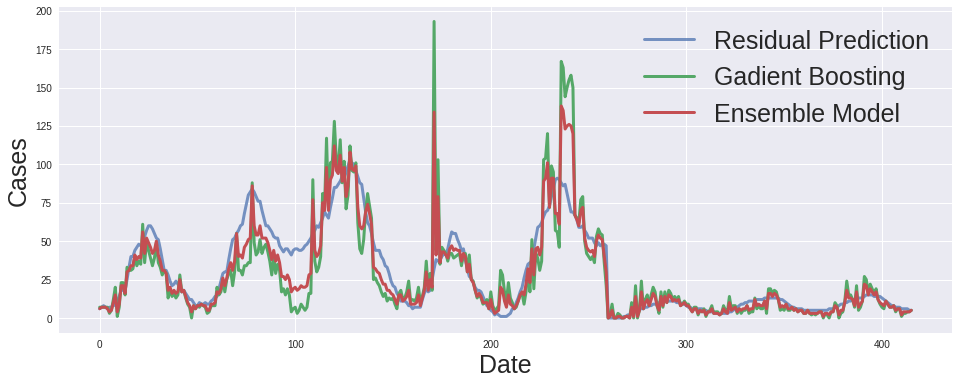

In [71]:
residuals = pd.read_csv('submissions/residual_prediction_1.csv')['total_cases']
rolling_window = pd.read_csv('submissions/rolling_window_GB_18:23.csv')['total_cases']
# random_forest = pd.read_csv('submissions/rolling_window_RF_18:23.csv')['total_cases']

ensemble_pred = pd.read_csv('submissions/ensemble_07-19-22-31_weighted_3_rounds.csv')

plt.figure(figsize=(16, 6))
plt.plot(residuals.index, residuals, label = 'Residual Prediction', linewidth = 3, alpha = .75)
plt.plot(rolling_window.index, rolling_window, label = 'Gadient Boosting', linewidth = 3)
plt.plot(ensemble_pred.index, ensemble_pred.total_cases, label = 'Ensemble Model', linewidth = 3)

# print (mean_absolute_error(pred_cases[:520], cases_iq))

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)